In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from omegaconf import OmegaConf
from ldm.util import instantiate_from_config
from diffusion import GaussianDiffusionSchedule

from dataset import FewShotDataset, mask_cmap_colors, mask_cmap

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import gc

device = torch.device("cuda:0")
# torch.cuda.set_device(0) # For multiple GPUs

## Load Stable Diffusion model

In [3]:
def load_model_from_config(config, ckpt, verbose=False):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location=device)
    if "global_step" in pl_sd:
        print(f"Global Step: {pl_sd['global_step']}")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys:")
        print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys:")
        print(u)

    model.to(device)
    model.eval()
    return model

config = OmegaConf.load(f"../../stable_diffusion/stable-diffusion/configs/stable-diffusion/v1-inference.yaml")
model = load_model_from_config(config, '../../stable_diffusion/stable-diffusion/models/ldm/stable-diffusion-v1/sd-v1-2.ckpt')
model = model.to(device)

Loading model from ../../stable_diffusion/stable-diffusion/models/ldm/stable-diffusion-v1/sd-v1-2.ckpt
Global Step: 245000
LatentDiffusion: Running in eps-prediction mode


/home/agraikos/anaconda3/envs/ldm/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:258: LightningDeprecationWarning: `pytorch_lightning.utilities.distributed.rank_zero_only` has been deprecated in v1.8.1 and will be removed in v2.0.0. You can import it from `pytorch_lightning.utilities` instead.
  rank_zero_deprecation(


DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.0.mlp.fc2.bias', 'vision_model.encoder.layers.2.layer_norm2.bias', 'vision_model.encoder.layers.6.self_attn.k_proj.weight', 'vision_model.encoder.layers.4.mlp.fc2.weight', 'vision_model.encoder.layers.10.self_attn.v_proj.weight', 'vision_model.encoder.layers.18.mlp.fc2.bias', 'vision_model.encoder.layers.8.self_attn.out_proj.bias', 'vision_model.encoder.layers.23.mlp.fc2.weight', 'vision_model.encoder.layers.16.mlp.fc1.weight', 'vision_model.encoder.layers.23.layer_norm1.weight', 'vision_model.encoder.layers.9.mlp.fc1.weight', 'vision_model.encoder.layers.22.self_attn.v_proj.bias', 'vision_model.encoder.layers.16.mlp.fc1.bias', 'vision_model.encoder.layers.22.self_attn.out_proj.weight', 'vision_model.encoder.layers.23.mlp.fc1.bias', 'vision_model.encoder.layers.8.mlp.fc1.weight', 'vision_model.encoder.layers.0.self_attn.k_proj.weight', 'visi

# Select features to use

In [4]:
# Add hooks
def get_features(name):
    def hook(model, input, output):
        features[name] = output
    return hook

# Concatenate feature maps into a single input tensor
def get_input(features):
    input_features = torch.cat((features['1'],
                                F.interpolate(features['2'], scale_factor=4),
                                ), dim=1)
    return input_features

# Intermediate layers to use
hook1 = model.model.diffusion_model.output_blocks[8].register_forward_hook(get_features('1'))
hook2 = model.model.diffusion_model.output_blocks[4].register_forward_hook(get_features('2'))

# Extract intermediate features
features = {}
with torch.no_grad():
    x = torch.randn((1,4,64,64)).float().to(device)
    t = torch.tensor([np.random.randint(0, 1000)]*x.shape[0]).float().to(device)
    uc = model.get_learned_conditioning([""]*x.shape[0])
    y = model.model.diffusion_model(x, t, context=uc)
y = get_input(features)
print('Using features of shape:', y.shape)

Using features of shape: torch.Size([1, 1920, 64, 64])


## Train segmentation network using denoiser features

In [5]:
# Dataset can be found at https://github.com/yandex-research/ddpm-segmentation
n_classes = 15
train_data = FewShotDataset('../../ffhq_seg/data/cat_15/real/train/', resize=(512,512))
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True, num_workers=0)
test_data = FewShotDataset('../../ffhq_seg/data/cat_15/real/test/', resize=(512,512))
test_dataloader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True, num_workers=0)

Loaded 30 images from '../../ffhq_seg/data/cat_15/real/train/'
Loaded 20 images from '../../ffhq_seg/data/cat_15/real/test/'


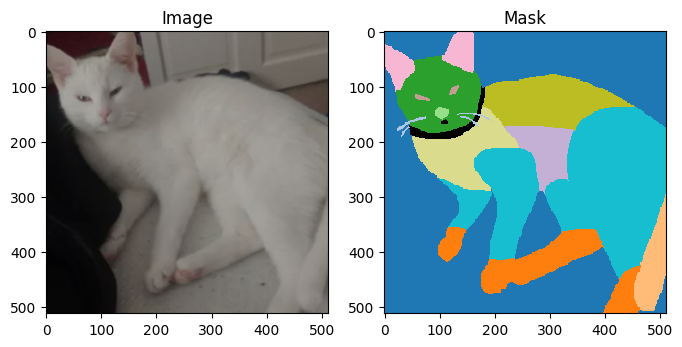

In [6]:
for batch in train_dataloader:
    img, mask = batch
    img = 2*img - 1
    break

fig, ax = plt.subplots(1, 2, figsize=(8,5))
ax[0].imshow((0.5*(img+1))[0].numpy().transpose([1,2,0]))
ax[0].set_title('Image')
ax[1].imshow(mask[0].numpy(), cmap=mask_cmap, vmin=0, vmax=n_classes, interpolation='none')
ax[1].set_title('Mask')
plt.show()

In [7]:
class SegNet(nn.Module):
    def __init__(self, in_ch=256, hidden=128, n_classes=15):
        super(SegNet, self).__init__()
        
        self.conv1 = nn.Conv2d(in_ch, hidden, 3, 1, 1)
        self.conv2 = nn.Conv2d(hidden, hidden, 3, 1, 1)
        self.conv3 = nn.Conv2d(hidden, hidden, 3, 1, 1)
        self.conv4 = nn.Conv2d(hidden, n_classes, 1)
        
        self.norm1 = nn.GroupNorm(32, hidden)
        self.norm2 = nn.GroupNorm(32, hidden)
        self.norm3 = nn.GroupNorm(32, hidden)
        
    def forward(self, x):
        x = self.norm1(F.relu(self.conv1(x)))
        x = F.interpolate(x, scale_factor=2)
        x = self.norm1(F.relu(self.conv2(x)))
        x = F.interpolate(x, scale_factor=2)
        x = self.norm1(F.relu(self.conv3(x)))
        x = F.interpolate(x, scale_factor=2)
        x = self.conv4(x)
        
        return x

# of parameters 2,509,839


  0%|          | 0/50 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


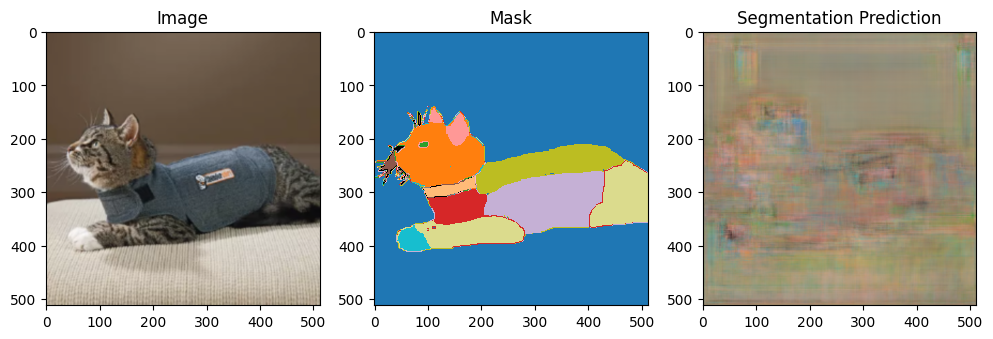

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


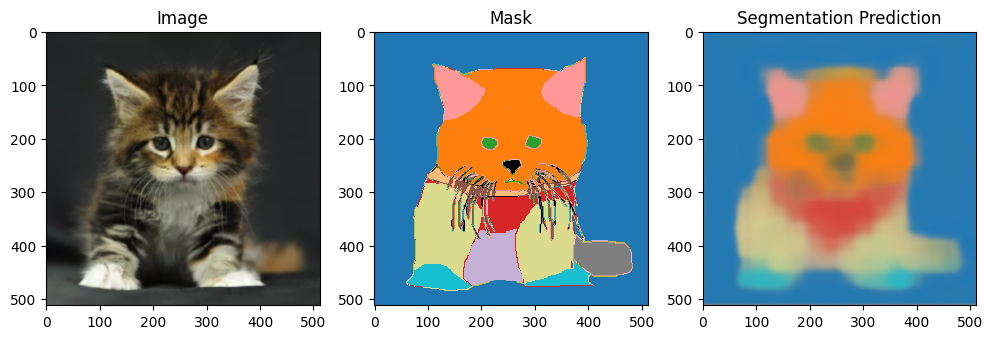

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


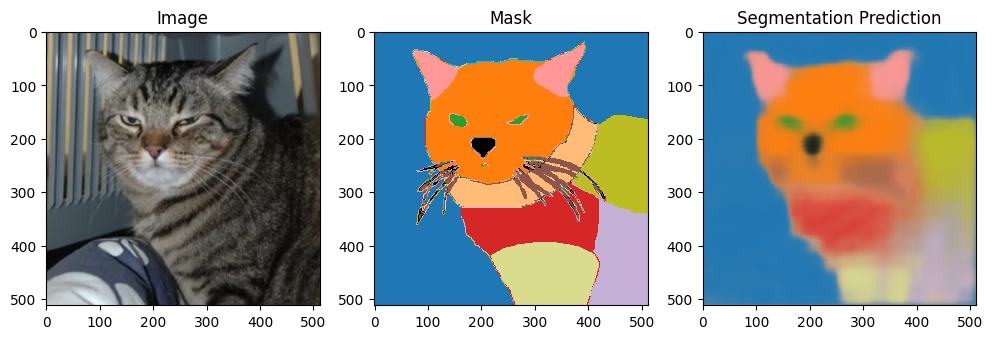

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


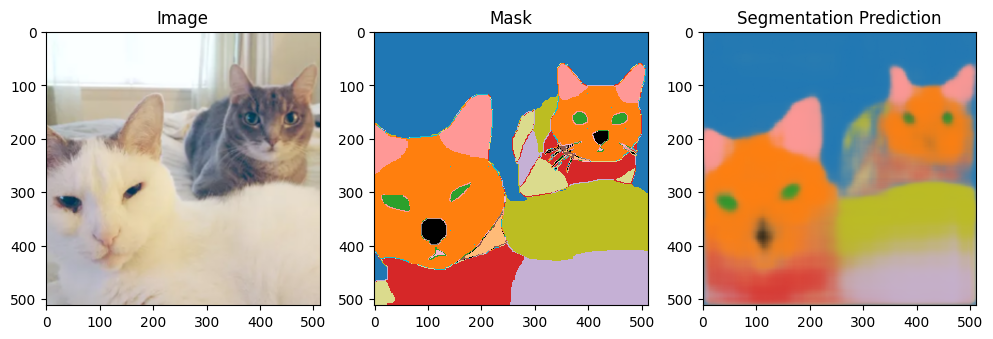

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


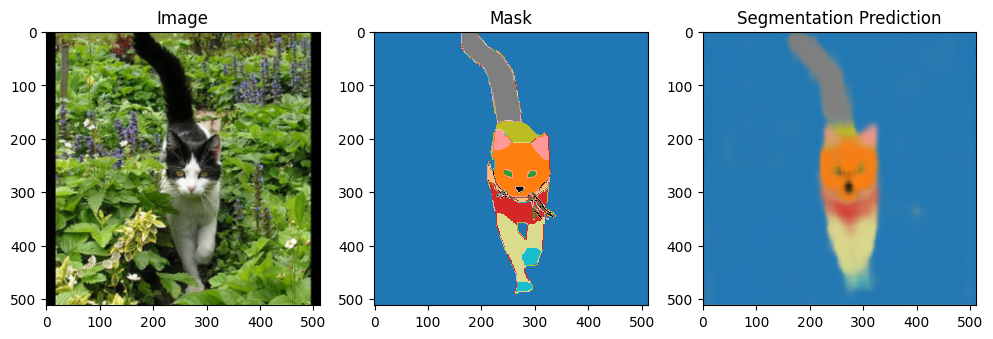

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


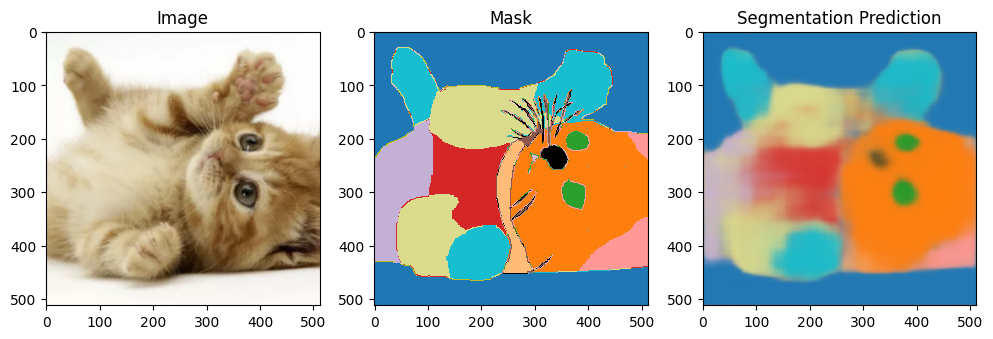

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


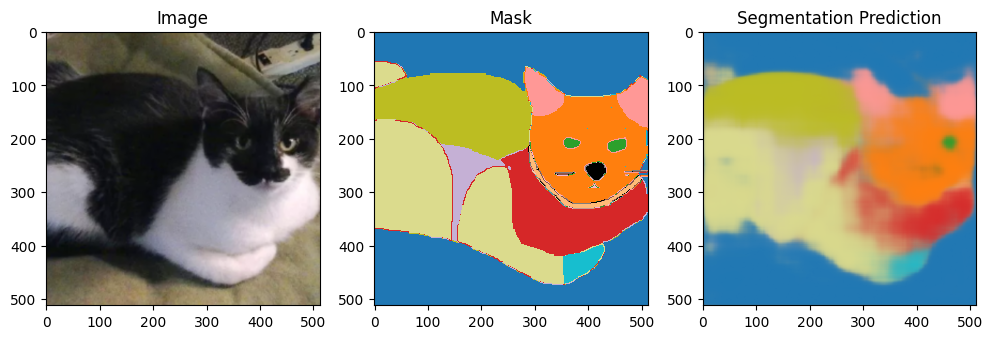

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


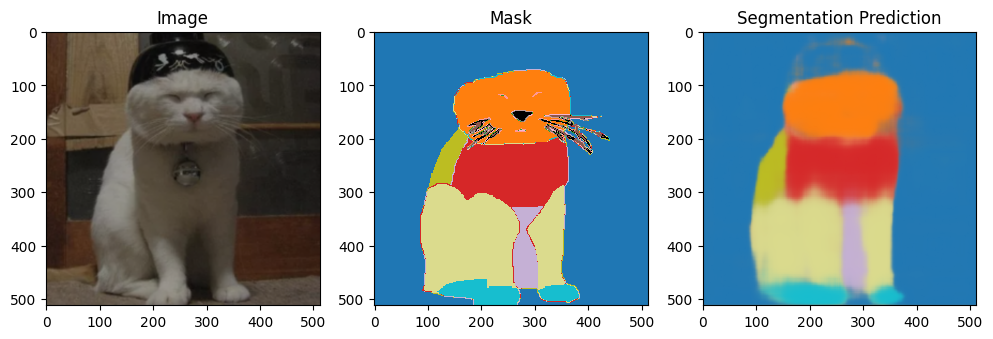

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


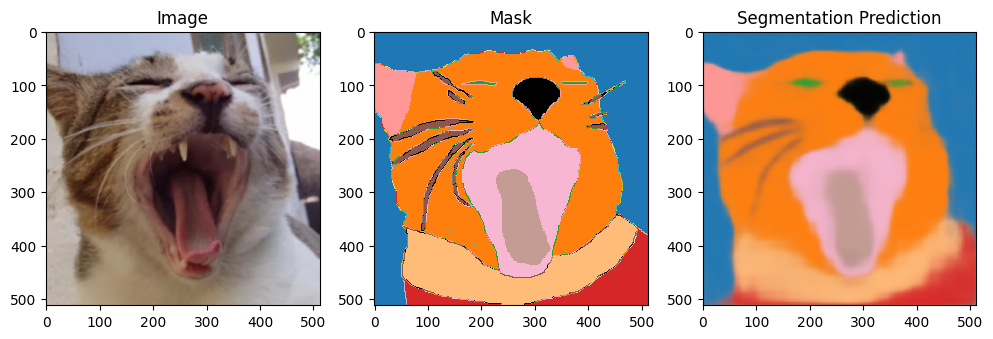

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


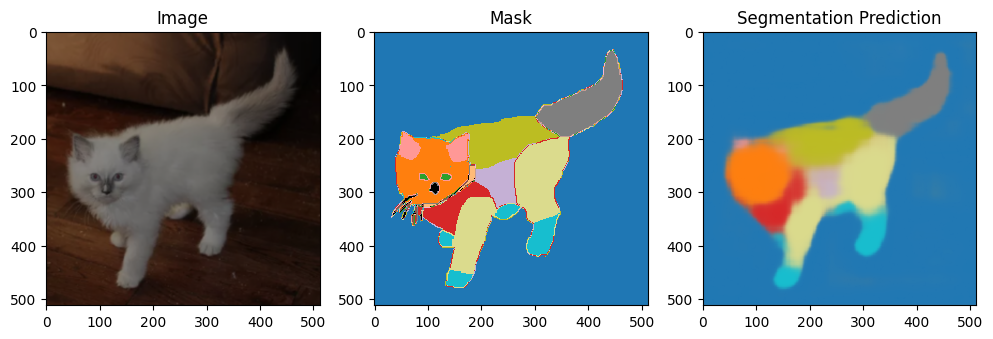

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


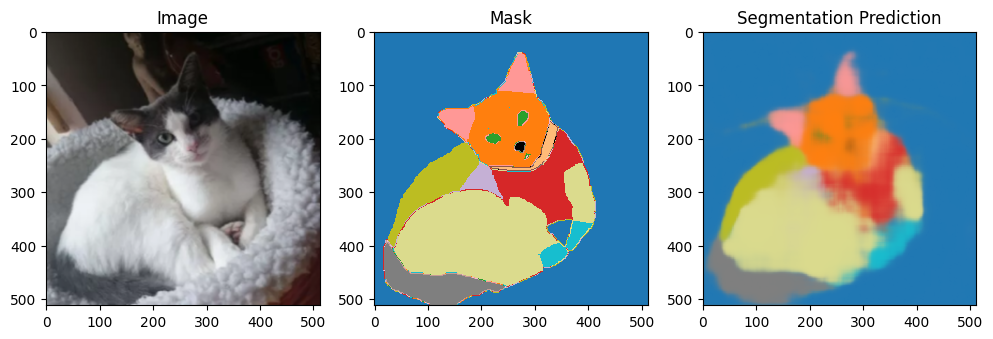

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


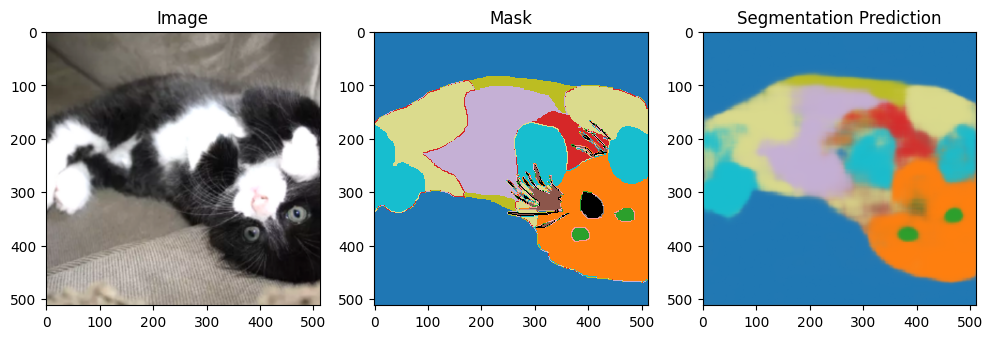

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


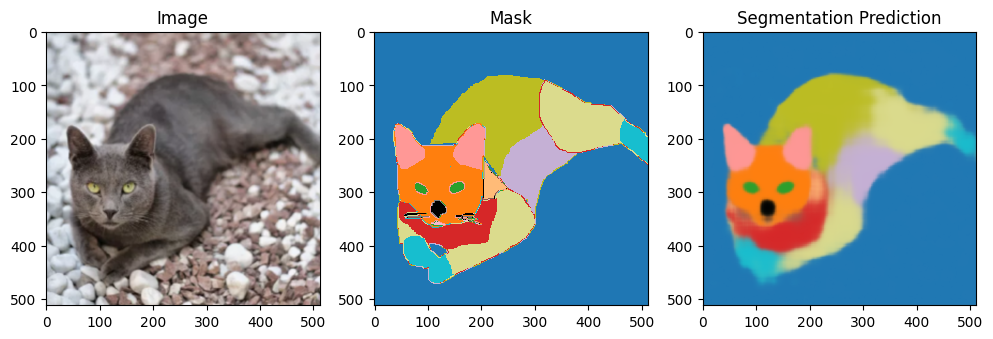

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


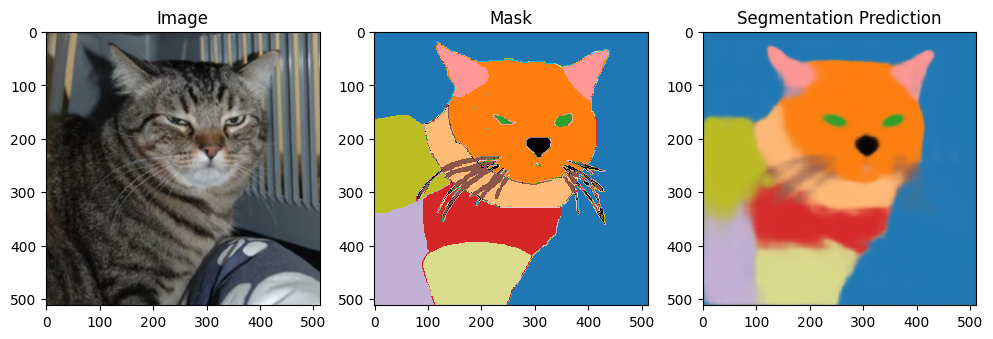

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


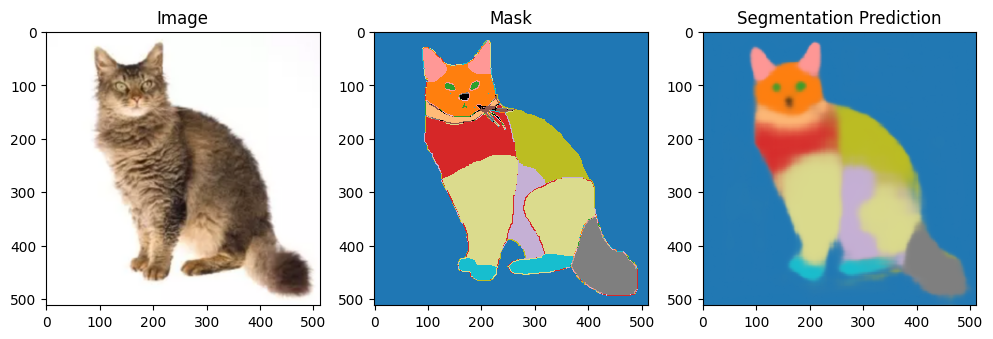

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


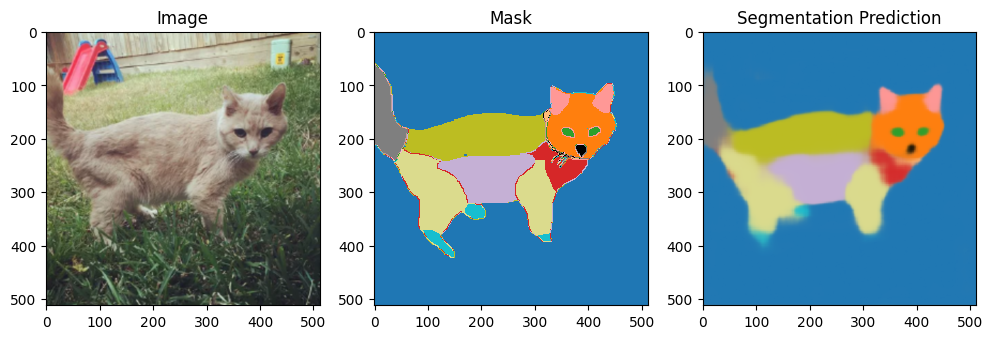

In [8]:
seg_model = SegNet(in_ch=1920).to(device)
seg_model.train()
print(f'# of parameters {sum([p.numel() for p in seg_model.parameters()]):,}')
opt = torch.optim.AdamW(seg_model.parameters(), lr=2e-4, weight_decay=1e-2)

model.eval()

# Text conditioning to use
with torch.no_grad():
    cond = model.get_learned_conditioning('an image of a cat')

t_features = 500 # Timestep to extract features at
epochs = 50 # Total epochs to train for
update_every = 20
vis_every = 25
i = 0
losses = []

progress_bar = tqdm(range(epochs))
for e in progress_bar:
    for batch in train_dataloader:
        img, mask = batch
        img = 2*img - 1
        
        # Get features from U-Net
        with torch.no_grad():            
            # Encode RGB image
            enc = model.get_first_stage_encoding(model.encode_first_stage(img.float().to(device)))
            # Denoise at specific timestep with chosen context prompt
            t = torch.tensor([t_features]*enc.shape[0]).float().to(device)
            y = model.model.diffusion_model(enc, t, context=cond.tile(enc.shape[0],1,1))
            # Get denoiser features
            input_features = get_input(features)
            
        # Predict logits
        logits = seg_model(input_features)
        # Compute loss   
        loss = F.cross_entropy(logits, mask.long().to(device))
        # Update parameters
        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())
        if i % update_every == 0:
            progress_bar.set_postfix({'Loss': np.mean(losses)})
            losses = []
            
        if i % vis_every == 0:
            img_vis = logits[0].softmax(0).detach().cpu().numpy()
            img_vis = np.einsum('lhw,ld->hwd', img_vis, mask_cmap_colors[:n_classes,:])
            # img_vis = logits[0].argmax(0).detach().cpu().numpy()

            fig, ax = plt.subplots(1, 3, figsize=(12,5))
            ax[0].imshow((0.5*(img+1))[0].numpy().transpose([1,2,0]))
            ax[0].set_title('Image')
            ax[1].imshow(mask[0].numpy(), cmap=mask_cmap, vmin=0, vmax=mask_cmap_colors.shape[0])
            ax[1].set_title('Mask')
            ax[2].imshow(img_vis)
            ax[2].set_title('Segmentation Prediction')
            plt.show()
        
        i += 1


In [9]:
# Clean-up
opt.zero_grad()
del opt
del loss
del logits
del input_features
del x

gc.collect()
torch.cuda.empty_cache()

## Guided inference

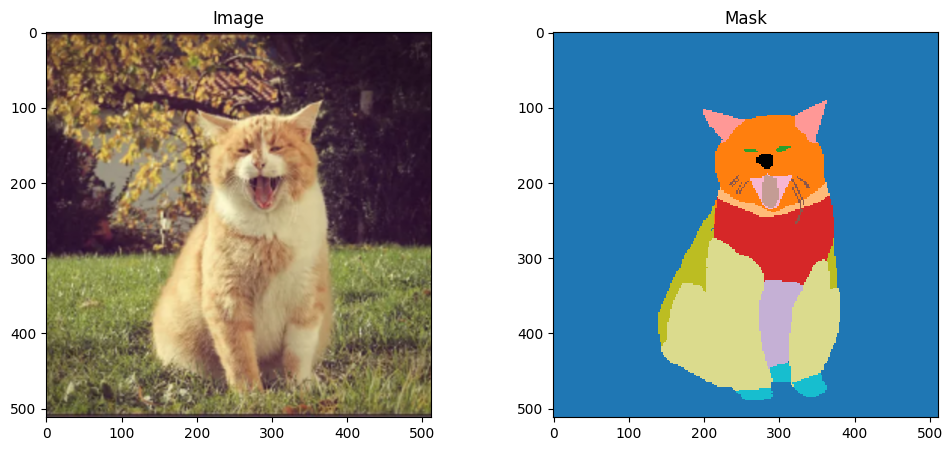

In [11]:
# Grab a random sample from the test set
for batch in test_dataloader:
    img, mask = batch
    img = 2*img - 1

    img = img[[0],...]
    mask = mask[[0],...]
    break

fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].imshow((0.5*(img+1))[0].numpy().transpose([1,2,0]))
ax[0].set_title('Image')
ax[1].imshow(mask[0].numpy(), cmap=mask_cmap, vmin=0, vmax=mask_cmap_colors.shape[0], interpolation='none')
ax[1].set_title('Mask')
plt.show()

Running diffusion with 100 steps


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


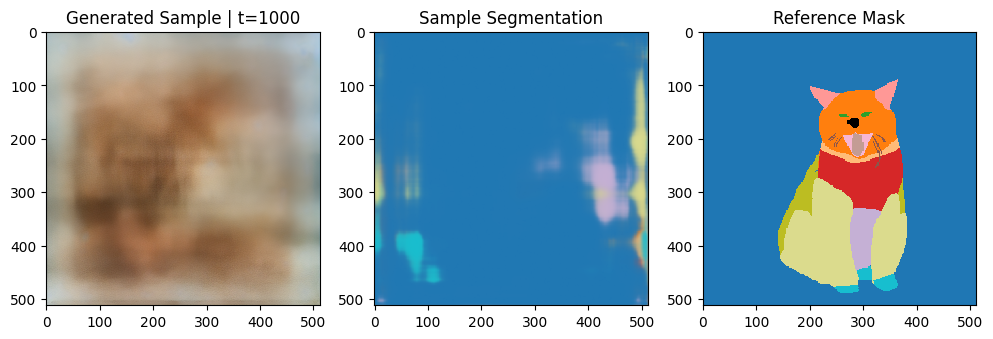

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


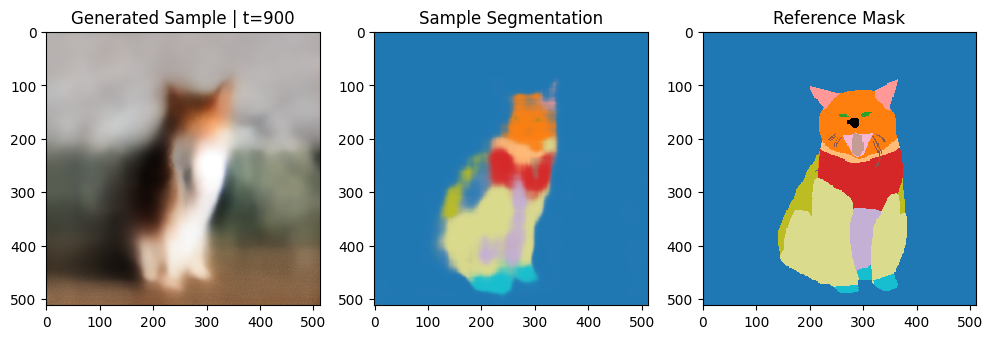

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


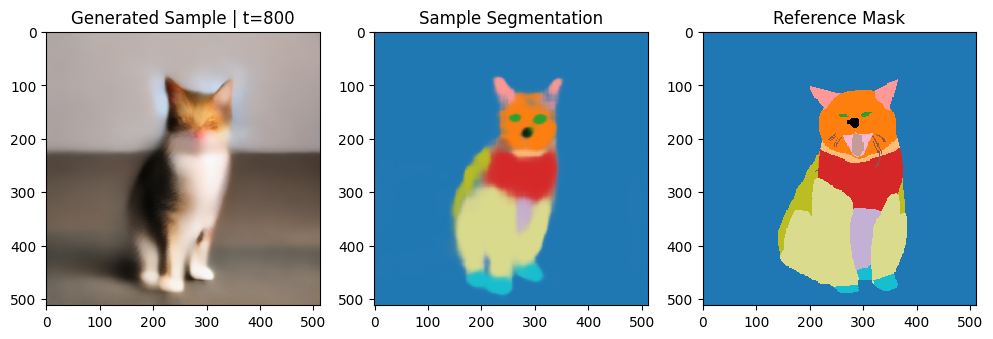

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


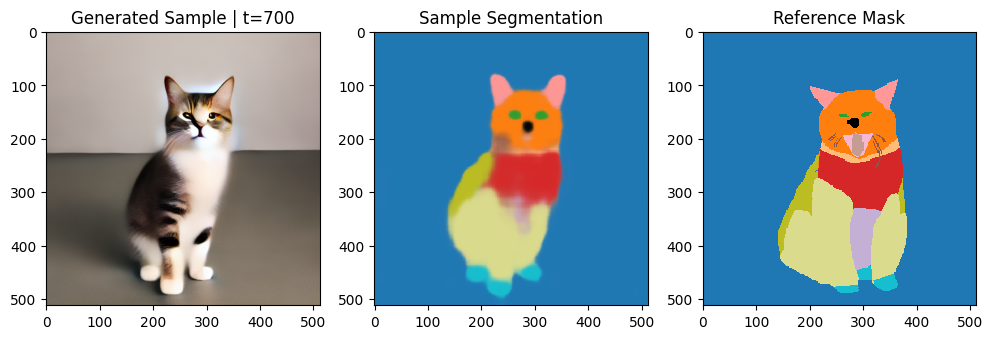

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


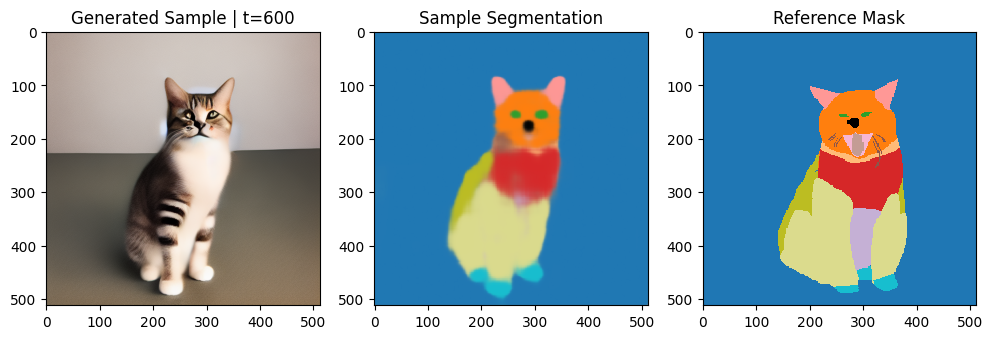

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


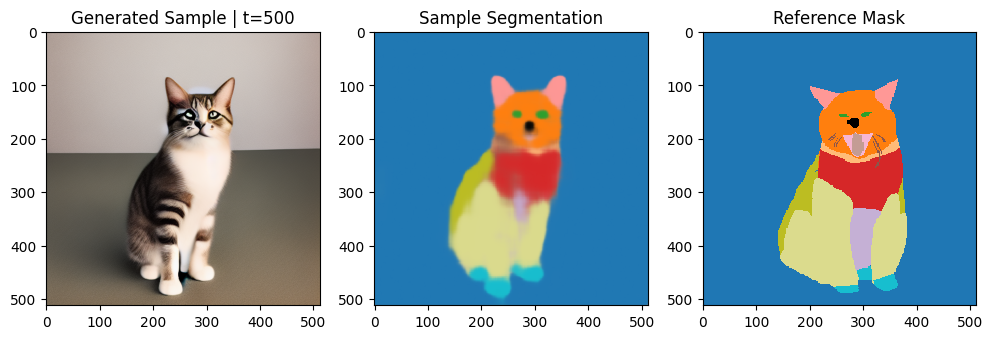

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


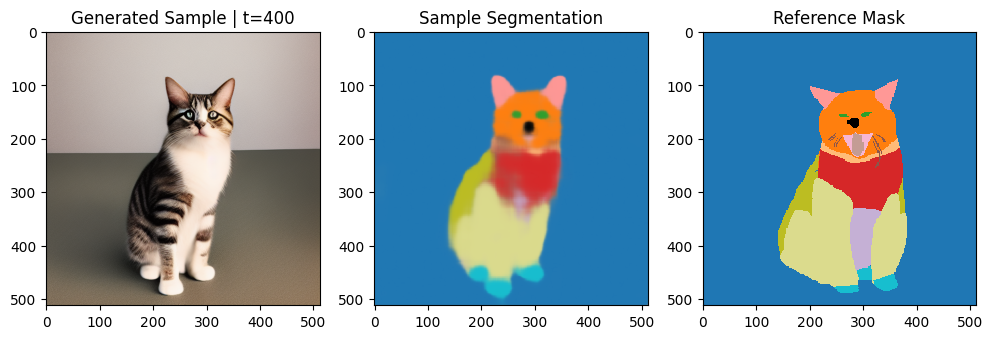

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


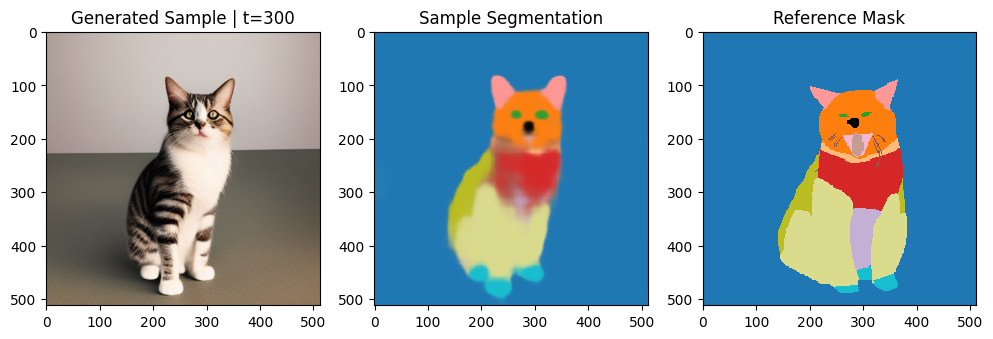

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


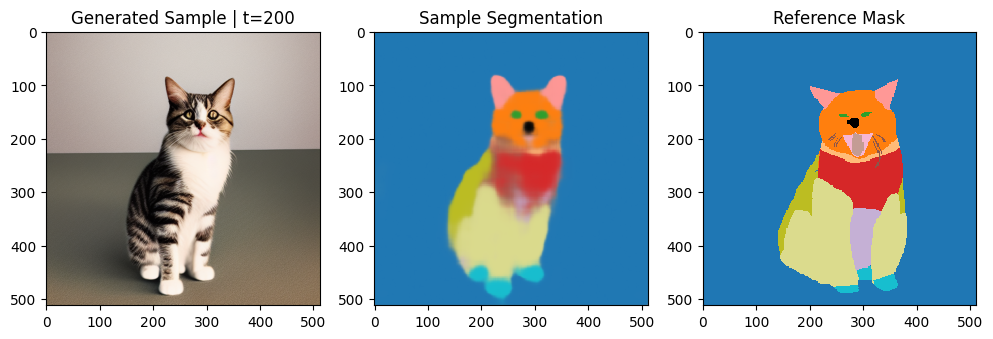

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


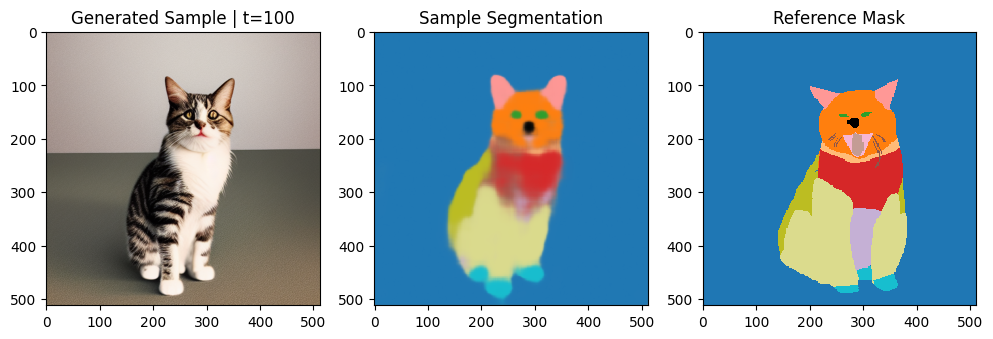

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


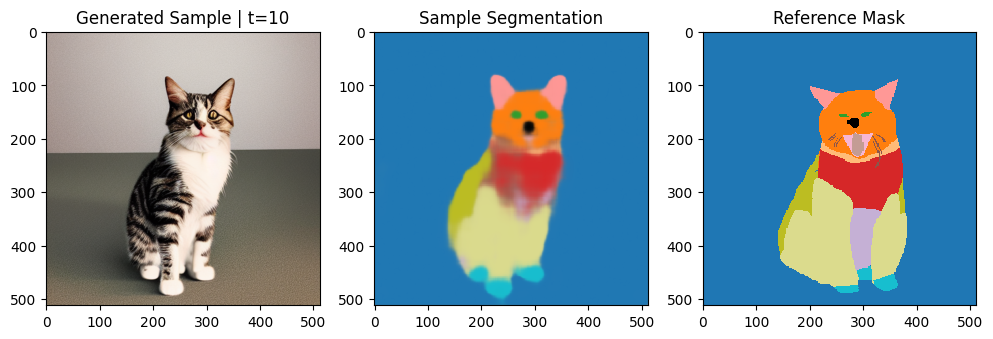

In [13]:
model.eval()
seg_model.eval()

# Initialize xT
t0 = 1000
x = torch.randn((1,4,64,64)).float().to(device)
x.requires_grad = True

# Reference mask
target = mask[0].tile(1,1,1).long().to(device)

# Text conditioning
with torch.no_grad():
    cond = model.get_learned_conditioning('an image of a cat') # Feature extraction conditioning
    img_cond = model.get_learned_conditioning('an image of a cat, standing, realistic photo')  # Generaton conditioning - it has to match the mask
    no_cond = model.get_learned_conditioning('') # No conditioning signal

# Guidance weights
text_guidance = 5.0
guidance_weight = 8

# Diffusion process parameters
stride = 10
start_t = t0
steps = t0
t_range = list(range(start_t, start_t-steps, -stride))
print(f"Running diffusion with {len(t_range)} steps")

ddim = 1
diffusion = GaussianDiffusionSchedule(T=1000, schedule=model.betas.cpu().numpy())

vis_every = 10

# Run inference
for j, t in enumerate(t_range):
    if j != len(t_range) - 1:
        stride = t - t_range[j+1]
    else:
        stride = t

    at = diffusion.alpha[t-1]
    atbar = diffusion.alphabar[t-1]

    # Diffusion score
    t_cond = torch.tensor([t]).view(-1)
    epsilon = ((1+text_guidance)*model.model.diffusion_model(x, t_cond.float().to(device), context=img_cond.tile(1,1,1))[:,:4,:,:]
                -text_guidance*model.model.diffusion_model(x, t_cond.float().to(device), context=no_cond.tile(1,1,1))[:,:4,:,:])
    # x0 estimation
    x0_pred = (x.float() / np.sqrt(atbar)) - (epsilon * np.sqrt((1-atbar)/atbar))

    # Learned guidance
    t_cond = torch.tensor([t_features]*x0_pred.shape[0]).float().to(device)
    y = model.model.diffusion_model(x0_pred, t_cond, context=cond.tile(x0_pred.shape[0],1,1))
    input_features = get_input(features)
    seg = seg_model(input_features)
    seg_loss = -guidance_weight*F.cross_entropy(seg, target)
    guidance_loss = seg_loss
    # Comptue mask-guidance score and update epsilon
    x.grad = None
    grad = torch.autograd.grad(guidance_loss, x, grad_outputs=torch.ones_like(guidance_loss))[0]    
    epsilon = epsilon - text_guidance*np.sqrt(1-atbar)*grad
    
    # Perform denoising step
    if t > stride:
        z = torch.randn_like(x)
        atbar_prev = diffusion.alphabar[t-1-stride]
        beta_tilde = diffusion.beta[t-1] * (1 - atbar_prev) / (1 - atbar) 
    else:
        z = torch.zeros_like(x)
        atbar_prev = 1
        beta_tilde = 0

    with torch.no_grad():
        beta_tilde = beta_tilde * ddim
        x = np.sqrt(atbar_prev) * (x - np.sqrt(1-atbar)*epsilon) / np.sqrt(atbar) + np.sqrt(1-atbar_prev-beta_tilde)*epsilon + np.sqrt(beta_tilde) * z
    x.requires_grad = True

    if (j % vis_every == 0) or (j == len(t_range)-1):
        with torch.no_grad():
            x0_pred_img = model.decode_first_stage(x0_pred)
        img_vis = seg[0].softmax(0).detach().cpu().numpy()
        img_vis = np.einsum('lhw,ld->hwd', img_vis, mask_cmap_colors[:n_classes,:])

        fig, ax = plt.subplots(1, 3, figsize=(12,5))
        ax[0].imshow((0.5*(x0_pred_img+1))[0].detach().cpu().numpy().transpose([1,2,0]))
        ax[0].set_title(f'Generated Sample | t={t}')
        ax[1].imshow(img_vis)
        ax[1].set_title('Sample Segmentation')
        ax[2].imshow(target[0].cpu().numpy(), cmap=mask_cmap, vmin=0, vmax=mask_cmap_colors.shape[0], interpolation='none')
        ax[2].set_title('Reference Mask')
        plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


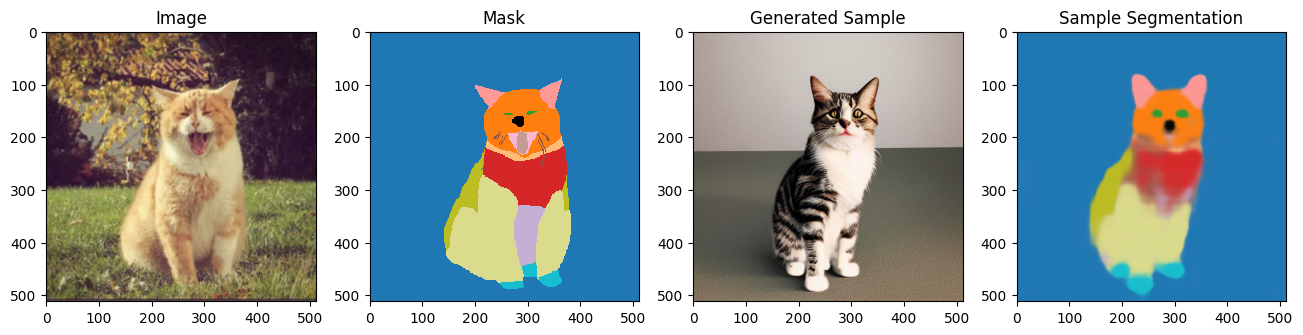

In [14]:
with torch.no_grad():
    x_img = model.decode_first_stage(x)
img_vis = seg[0].softmax(0).detach().cpu().numpy()
img_vis = np.einsum('lhw,ld->hwd', img_vis, mask_cmap_colors[:n_classes,:])

fig, ax = plt.subplots(1, 4, figsize=(16,5))
ax[0].imshow((0.5*(img+1))[0].numpy().transpose([1,2,0]))
ax[0].set_title('Image')
ax[1].imshow(mask[0].numpy(), cmap=mask_cmap, vmin=0, vmax=mask_cmap_colors.shape[0], interpolation='none')
ax[1].set_title('Mask')
ax[2].imshow((0.5*(x_img+1))[0].detach().cpu().numpy().transpose([1,2,0]))
ax[2].set_title('Generated Sample')
ax[3].imshow(img_vis)
ax[3].set_title('Sample Segmentation')
plt.show()